# 过程设计 

1. 读取源数据
2. 按数据表都数据段
3. 提取数据段特征
   - 原始心电图的特征（60）：频谱功率0–6 Hz（每0.1 Hz）

   - HRV特征（10）：平均值、标准差、偏度、峰度、均方根、连续差异的均方根、高于平均值+标准差的点百分比、低于平均值-标准差的点数百分比、低频频谱功率（0.01–0.08 Hz），中频谱功率（0.08–0.15 Hz）、高频谱功率（0.15–0.50 Hz）。

   - HR特征（6）：均值、标准差、偏度、峰度、高于均值的百分比+标准差、低于均值的百分比-标准差
4. 保存特征

In [1]:
def setProjectPath(projectPath):
    import os
    import sys
    root=os.path.abspath(projectPath)
    print(root)
    sys.path.append(root)
    os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
    import warnings  
    warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")

projectPath=r'D:\project_meta\NNproject\NNI'
setProjectPath(projectPath)

D:\project_meta\NNproject\NNI


In [2]:
import mne
datasetFolder=r'D:\dataset\driver_dataset\DROZY\DROZY'
outputFolder=r'D:\project_meta\NNproject\NNI\output'
from project.dataprocess.FolderTree import *
datasetDict=getDataPath(datasetFolder)
outputDict=getOutPath(outputFolder)
import pprint
pprint.pprint(datasetDict)
pprint.pprint(outputDict)

{'annotation_auto_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\annotations-auto',
 'annotation_manual_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\annotations-manual',
 'kinect_file': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\kinect-intrinsics.yaml',
 'kss_file': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\KSS.txt',
 'psg_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\psg',
 'pvt_rt_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\pvt-rt',
 'videos_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\videos_i8'}
{'ECG_filted_folder': 'D:\\project_meta\\NNproject\\NNI\\output\\psg_filted\\ECG',
 'ECG_table_file': 'D:\\project_meta\\NNproject\\NNI\\output\\ECG_table.csv',
 'ECG_uniformfilted_folder': 'D:\\project_meta\\NNproject\\NNI\\output\\psg_filted\\ECG',
 'EEG_filted_folder': 'D:\\project_meta\\NNproject\\NNI\\output\\psg_filted\\EEG',
 'EEG_table_file': 'D:\\project_meta\\NNproject\\NNI\\output\\EEG_table.csv',
 'EEG_uniformfilted_folder': 'D:\\project_

# 读取数据


In [3]:
from project.dataset.BaseDataset import *
from project.dataset.ExtendDataset import *
from project.dataprocess.SignalProcess import *
import pandas as pd
from project.dataprocess.FolderTree import *
from project.dataprocess.ECGSignalProcess import *
import matplotlib.pyplot as plt
import os
from biosppy.signals import ecg
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

controlTable=pd.read_csv(outputDict['windowsTable'])
ecgDataset=TableControlECGDataset(controlTable,datasetDict['psg_folder'],fix_len=False)
data=ecgDataset[0]
signals=data['data'][0]
time=data['time']

## 数据预处理

Setting up low-pass filter at 0.01 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.01 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.01 Hz)
- Filter length: 845 samples (1.650 s)

Setting up low-pass filter at 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 6.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 845 samples (1.650 s)



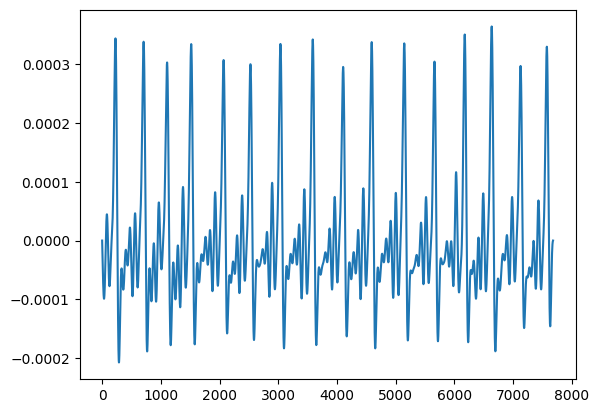

In [4]:
signals=Denoising(signal=signals,sfreq=512)
signals=Calibration_direction(signal=signals,sfreq=512)
filed_signal=mne.filter.filter_data(signals,sfreq=512,l_freq=0,h_freq=6)
plt.plot(filed_signal)

# 提取特征

## 提取R峰

In [7]:
from biosppy.signals import ecg
from biosppy.storage import load_txt
result=ecg.ecg(signals,512,interactive=False,show=False)
result_dict=result.as_dict()


In [10]:
result_dict.keys()

odict_keys(['ts', 'filtered', 'rpeaks', 'templates_ts', 'templates', 'heart_rate_ts', 'heart_rate'])

In [8]:
Rpeak_ms=np.diff(result_dict['rpeaks'])/512*1000

## R峰特征

- mean_nni     RR间期平均值
- sdnn         RR间期标准差
- sdsd         相邻RR之间差异的标准差
- rmssd        相邻RR间期的差方和的均值的平方根，反映高频(快速或副交感神经)对hrV的影响
- median_nni   RR间隔差的中位数的绝对值
- nni_50       连续RR间期间隔差大于50ms的数量
- pnni_50      用nni_50 / RR间期数量
- nni_20       连续RR间期间隔差大于20ms的数量
- pnni_20      用nni_20 / RR间期数量
- range_nni    RR间期最大值和最小值的差异
- cvcd         连续差异的变化系数 = rmssd / mean_nni
- cvnni        变异系数 = sdnn / mean_nni
- mean_hr      平均心率
- max_hr       最大心率
- min_hr       最小心率
- std_hr       心率标准差

In [9]:
from hrvanalysis import get_time_domain_features
get_time_domain_features(Rpeak_ms)

{'mean_nni': 958.0078125,
 'sdnn': 95.51053153574104,
 'sdsd': 115.12766863382222,
 'nni_50': 11,
 'pnni_50': 84.61538461538461,
 'nni_20': 11,
 'pnni_20': 84.61538461538461,
 'rmssd': 115.33491580386911,
 'median_nni': 977.5390625,
 'range_nni': 298.828125,
 'cvsd': 0.12039037082891128,
 'cvnni': 0.09969702782120166,
 'mean_hr': 63.2437920125524,
 'max_hr': 76.41791044776119,
 'min_hr': 55.351351351351354,
 'std_hr': 6.419919327580528}

## HRV特征

- total_power   总功率密度谱
- vlf           极低频时（0.003-0.04hz）HRV的方差，反映心脏产生的内在节律，受交感神经活动调节
- lf            低频时（0.04-0.15hz）HRV的方差，反映交感神经和副交感神经活动
- hf            高频时（0.15-40hz）HRV的方差，反映了由副交感神经(迷走神经)活动引起的一拍一拍变异性的快速变化。
- lf_hf_ratio   等于 lf / hf
- lfnu          归一化低频功率
- hfnu          归一化高频功率

In [11]:
from hrvanalysis import get_frequency_domain_features
get_frequency_domain_features(Rpeak_ms)

g:\install\anaconda\envs\nni\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 51, using nperseg = 51
  warnings.warn('nperseg = {0:d} is greater than input length '


{'lf': 1099.2429862811887,
 'hf': 1228.8823509655767,
 'lf_hf_ratio': 0.8945062848510065,
 'lfnu': 47.215799282574295,
 'hfnu': 52.7842007174257,
 'total_power': 3100.266378954939,
 'vlf': 772.1410417081736}

## 原始心电图特征

In [25]:
import pywt
data=filed_signal
totalscal = 512
sampling_rate=512
wavename = "cgau8"
highest_frequency=6
resolution_ratio=0.1
lowes_tfrequency=0


fc = pywt.central_frequency(wavename)  # 计算小波函数的中心频率
cparam = 2 * fc * totalscal  # 常数c\
highest_frequency=2*highest_frequency
resolution_ratio=-1*(resolution_ratio*2)
scales=cparam/np.arange(highest_frequency, lowes_tfrequency, resolution_ratio)  # 为使转换后的频率序列是一等差序列，尺度序列必须取为这一形式（也即小波尺度）
[cwtmatr, frequencies] = pywt.cwt(data, scales, wavename, 1.0/sampling_rate)  # 连续小波变换模块

In [20]:
faw_feature=np.sum(abs(cwtmatr)**2,axis=1)

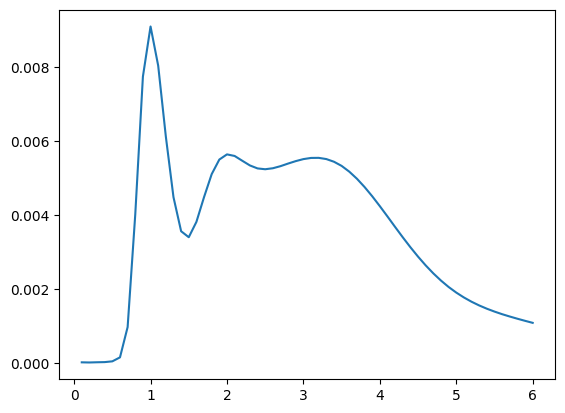

In [24]:
plt.plot(frequencies,faw_feature)

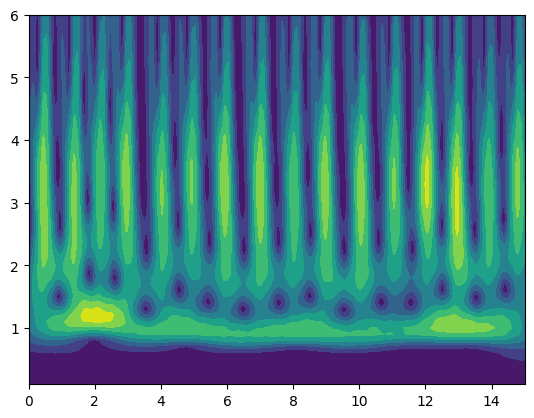

In [14]:
plt.figure()
plt.contourf(time, frequencies, abs(cwtmatr))

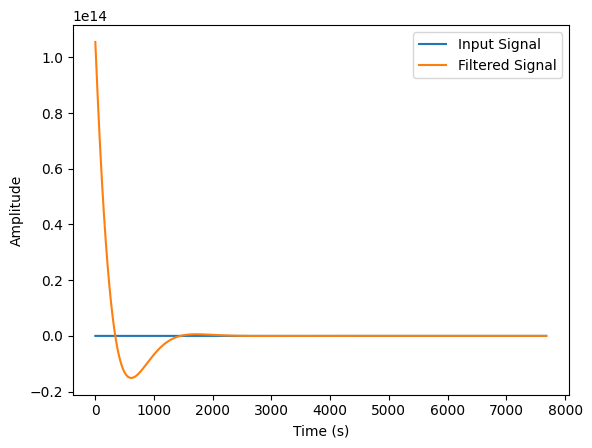

In [23]:
signal_filtered = signal.filtfilt(b, a, signals)
plt.figure()
plt.plot( signals, label='Input Signal')
plt.plot(signal_filtered, label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [38]:

data=ecgDataset[0]
signals=data['data'][0]
signals=Denoising(signal=signals,sfreq=512)
signals=Calibration_direction(signal=signals,sfreq=512)
signals=mne.filter.filter_data(signals,sfreq=512,l_freq=0,h_freq=6)

resolution_ratio=0.05
sfreq=512
length_pad=int((1/resolution_ratio)*sfreq-len(signals))
if length_pad>0:
    signals=np.pad(signals,(0,length_pad),mode='constant', constant_values=0)
fft_result,freq=FFTParse(signals,sfreq=512)
print(int(len(freq)/2))
print(freq[int(len(freq)/2):int(len(freq)/2+10)])

0.0 15.0
Setting up low-pass filter at 0.01 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.01 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.01 Hz)
- Filter length: 845 samples (1.650 s)

Setting up low-pass filter at 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 6.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 845 samples (1.650 s)

10240.0
7680
5120
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45]


In [ ]:
power_a=SignalPowerBandTime(signals,sfreq=512,l_freq=0.01,h_freq=0.08)
power_b=SignalPowerBandTime(signals,sfreq=512,l_freq=0.08,h_freq=0.15)
power_c=SignalPowerBandTime(signals,sfreq=512,l_freq=0.15,h_freq=0.5)
power_a,power_b,power_c

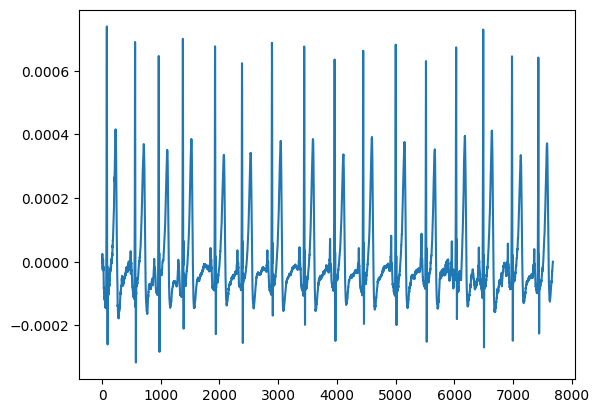

In [6]:
import matplotlib.pyplot as plt
plt.plot(signals)

In [4]:
controlTable

,Unnamed: 0,ID,LEVEL,KSS,START,END
0,0,1.0,1.0,3.0,0.0,15.0
1,1,1.0,1.0,3.0,15.0,30.0
2,2,1.0,1.0,3.0,30.0,45.0
3,3,1.0,1.0,3.0,45.0,60.0
4,4,1.0,1.0,3.0,60.0,75.0
...,...,...,...,...,...,...
1435,1435,9.0,3.0,8.0,525.0,540.0
1436,1436,9.0,3.0,8.0,540.0,555.0
1437,1437,9.0,3.0,8.0,555.0,570.0
1438,1438,9.0,3.0,8.0,570.0,585.0


In [5]:
ecgDataset[0].keys()

0.0 15.0


dict_keys(['data', 'time', 'index', 'KSS', 'LEVEL'])

In [9]:
import mne
data=ecgDataset[1]
filed_data=mne.filter.filter_data(data['data'],sfreq=512,l_freq=0.01,h_freq=6).T

15.0 30.0
Setting up band-pass filter from 0.01 - 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 6.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 168961 samples (330.002 s)



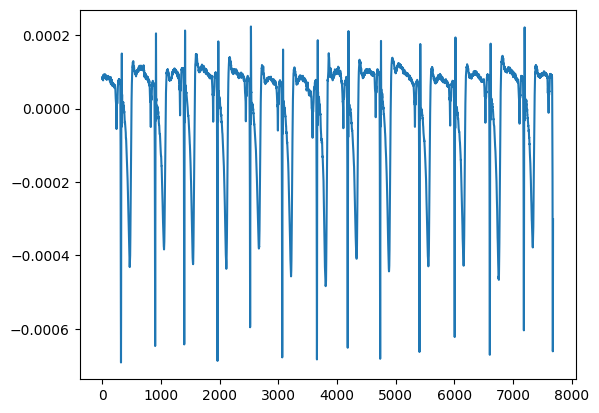

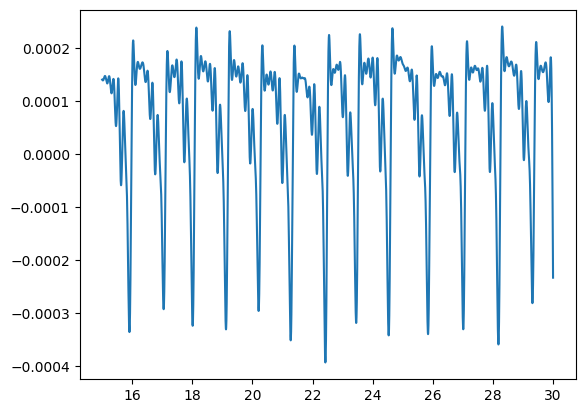

In [10]:
import matplotlib.pyplot as plt
import os
from biosppy.signals import ecg

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
plt.figure()
plt.plot(data['data'].T)
plt.figure()
plt.plot(data['time'],filed_data)


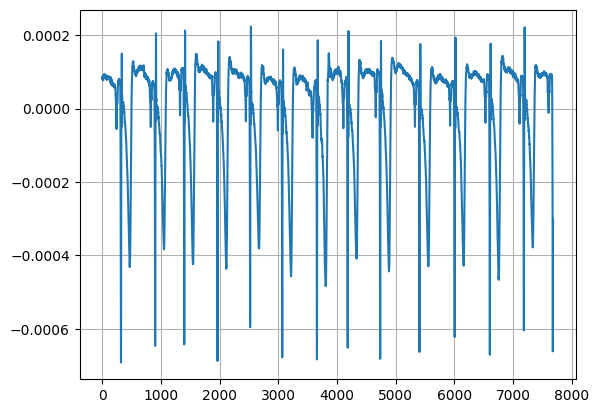

(7680,)


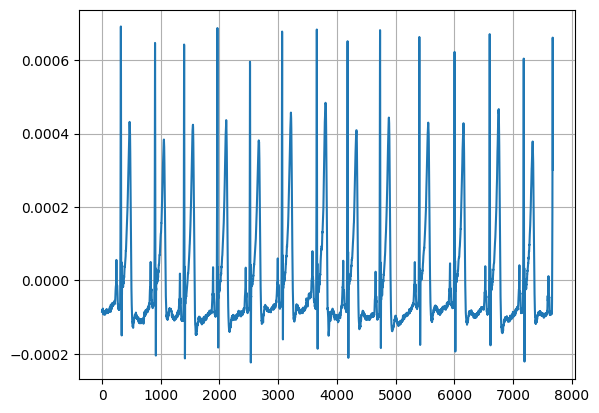

In [19]:
signals=data['data'][0]
plt.figure()
plt.grid(True)
plt.plot(signals)
plt.show()
sfreq=512
print(signals.T.shape)
rpeaks0=ecg.hamilton_segmenter(signals.T,sfreq)
rpeaks1=ecg.christov_segmenter(-1*signals,sfreq)
if sum(signals[rpeaks0[0]])<sum(-1*signals[rpeaks1[0]]):
    signals=-1*signals
plt.figure()
plt.grid(True)
plt.plot(signals)
plt.show()

In [23]:
from project.dataprocess.SignalProcess import *
import numpy as np
n=10
fft_result,freq=FFTParse(np.pad(filed_data, (0, (n-1)*len(filed_data)), mode='constant', constant_values=0),sfreq=512)
np.diff(freq)

NameError: name 'filed_data' is not defined

In [23]:
import pywt
data=filed_data
totalscal = 512
sampling_rate=512
wavename = "cgau8"
highest_frequency=0.5
resolution_ratio=0.01
fc = pywt.central_frequency(wavename)  # 计算小波函数的中心频率
cparam = 2 * fc * totalscal  # 常数c\
highest_frequency=2*highest_frequency
resolution_ratio=-1*(resolution_ratio*2)
scales=cparam/np.arange(highest_frequency, 0.01, resolution_ratio)  # 为使转换后的频率序列是一等差序列，尺度序列必须取为这一形式（也即小波尺度）
[cwtmatr, frequencies] = pywt.cwt(data, scales, wavename, 1.0/sampling_rate)  # 连续小波变换模块

MemoryError: Unable to allocate 13.7 GiB for an array with shape (2560, 358401) and data type complex128

In [24]:
frequencies

array([0.5 , 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4 ,
       0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.3 , 0.29,
       0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.2 , 0.19, 0.18,
       0.17, 0.16, 0.15, 0.14, 0.13, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.07,
       0.06, 0.05, 0.04, 0.03])

In [9]:
np.diff(freq)

array([0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02])

In [10]:
freq[int(len(freq)/2):int(len(freq)/2)+1000]

array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
        0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
        0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
        0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
        0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
        0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ,  1.02,  1.04,  1.06,
        1.08,  1.1 ,  1.12,  1.14,  1.16,  1.18,  1.2 ,  1.22,  1.24,
        1.26,  1.28,  1.3 ,  1.32,  1.34,  1.36,  1.38,  1.4 ,  1.42,
        1.44,  1.46,  1.48,  1.5 ,  1.52,  1.54,  1.56,  1.58,  1.6 ,
        1.62,  1.64,  1.66,  1.68,  1.7 ,  1.72,  1.74,  1.76,  1.78,
        1.8 ,  1.82,  1.84,  1.86,  1.88,  1.9 ,  1.92,  1.94,  1.96,
        1.98,  2.  ,  2.02,  2.04,  2.06,  2.08,  2.1 ,  2.12,  2.14,
        2.16,  2.18,  2.2 ,  2.22,  2.24,  2.26,  2.28,  2.3 ,  2.32,
        2.34,  2.36,  2.38,  2.4 ,  2.42,  2.44,  2.46,  2.48,  2.5 ,
        2.52,  2.54,

In [ ]:
import numpy as np

# 假设data是原始数据的数组
data = np.array([1, 2, 3, 4, 5])

# 指定填充的宽度和填充值
pad_width = 2
pad_value = 0
n=10
# 给数据添加填充
padded_data = np.pad(data, (0, (n-1)*len(data)), mode='constant', constant_values=pad_value)

# 显示结果
print("原始数据：", data)
print("填充后的数据：", padded_data)

原始数据： [1 2 3 4 5]
填充后的数据： [1 2 3 4 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [83]:
from project.dataprocess.SignalProcess import *
x,y,power=CreateSignal(A=1)
power_=SignalPowerBandTime(y,sfreq=512,l_freq=0.5,h_freq=1.5)
power_a=SignalPowerBandTime(y,sfreq=512,l_freq=1.999,h_freq=2.001)
power_b=SignalPowerBandTime(y,sfreq=512,l_freq=2.99,h_freq=3.001)

resolution_ratio=0.1
sfreq=512
length_pad=int((1/resolution_ratio)*sfreq-len(y))
if length_pad>0:
    y=np.pad(y,(0,length_pad),mode='constant', constant_values=0)
    print(len(y))
fft,freq=FFTParse(y,sfreq=512)
idx_band=np.logical_and(7<=freq,freq<=8)
bandPower=np.sum(abs(fft[idx_band])**2*2,axis=0)
# print(bandPower.shape)
# freq[5120:5120+512]
bandPower,power
# PlotAFR(fft,freq)

Setting up band-pass filter from 0.5 - 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 1.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Filter length: 3381 samples (6.604 s)

Setting up band-pass filter from 2 - 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filte

(0.03815297311723621, 10.0)

0.0009523809523841464
[0.00000000e+00 9.52380952e-04 1.90476190e-03 ... 2.54998095e+02
 2.54999048e+02 2.55000000e+02]
频域能量: 149.98046238828448
时域能量: 149.98046875000017


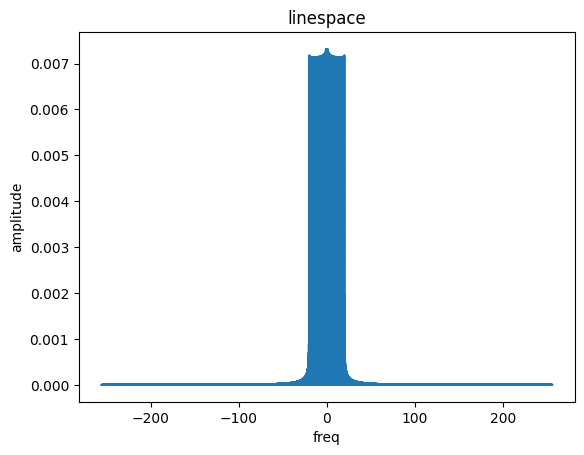

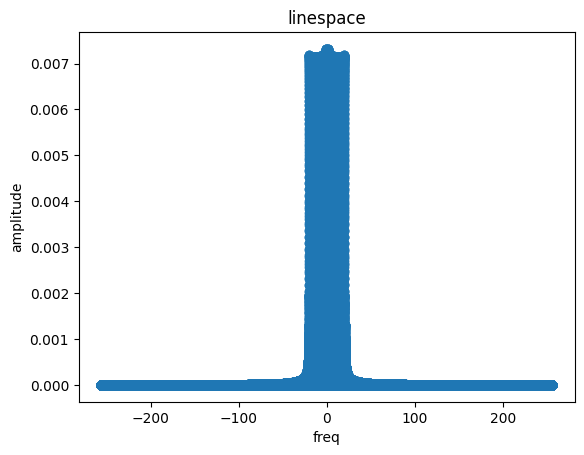

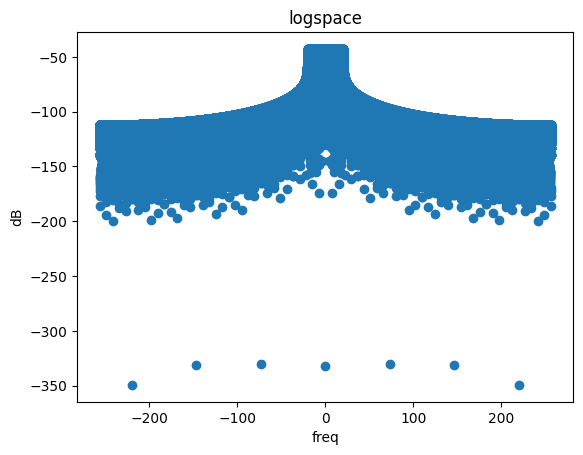

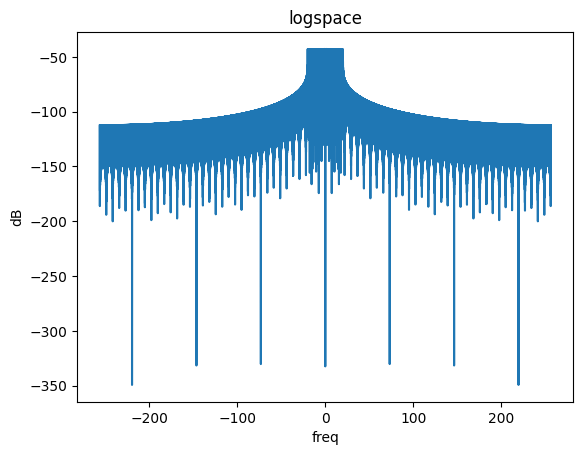

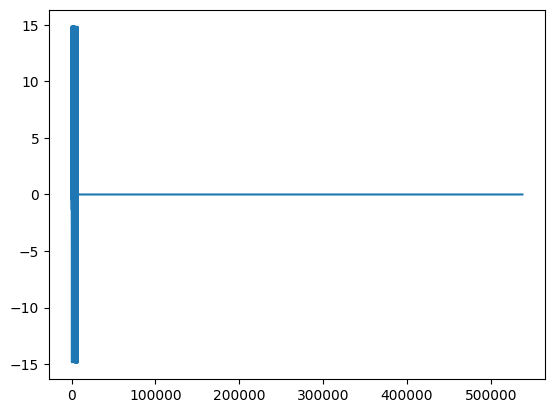

In [274]:
from project.dataprocess.SignalProcess import *
length=15
A=1

fs=np.linspace(1,20,20).reshape((-1,1))
x=np.linspace(0,length*1,length*512)
y=A*np.sin(2*np.pi*x*fs)
y=np.sum(y,axis=0)

#y=np.exp(x)


y=np.pad(y,(0,69*len(y)),mode='constant',constant_values=0)

fft,freq=FFTParse(y,sfreq=512)
dw=np.diff(freq)[0]
print(dw)
idx_band=np.logical_and(0<=freq,freq<=255)
print(freq[idx_band])
FreqPower=np.sum(abs(fft[idx_band])**2*2*dw,axis=0)*(len(y)/sfreq)**2
print('频域能量:',FreqPower)

TimePower=sum(abs(y)**2)/sfreq
print('时域能量:',TimePower)
PlotAFR(fft,freq)
plt.figure()
plt.plot(y)

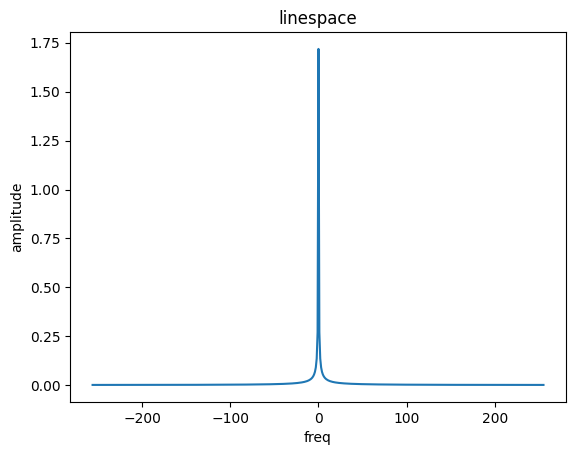

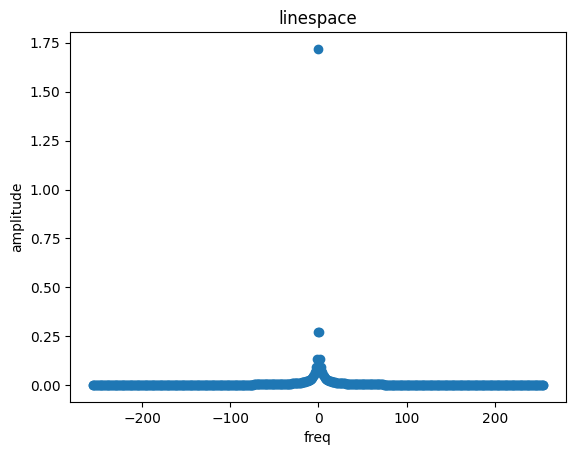

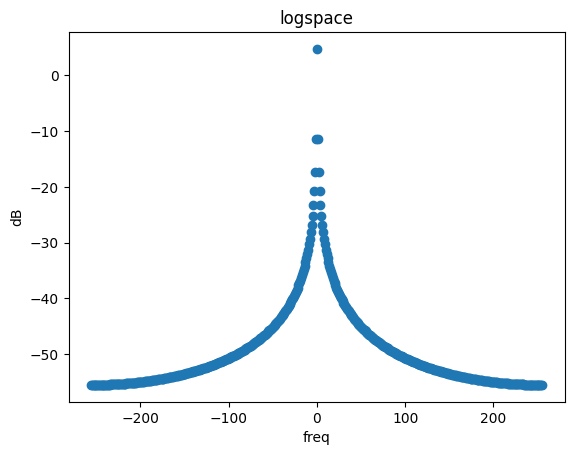

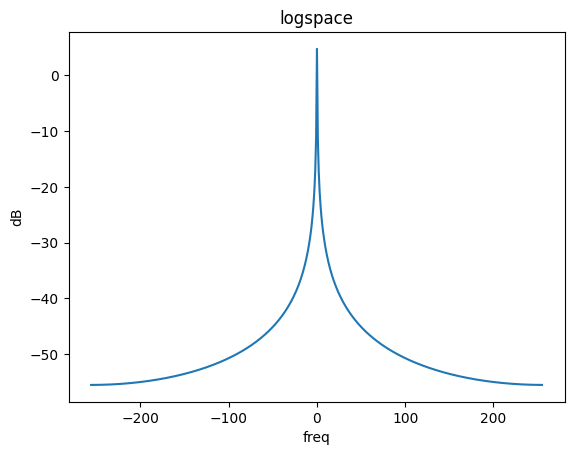

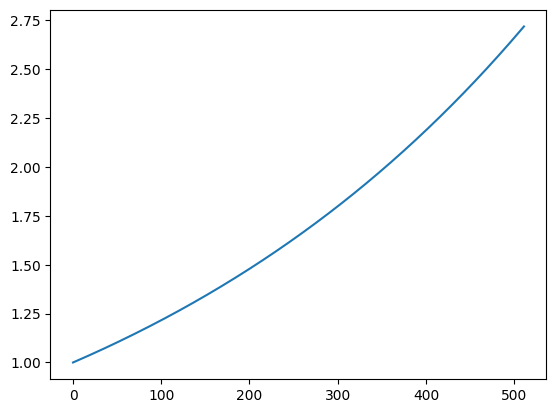

In [183]:
power_b=sum(abs(y)**2)/sfreq
power_b

3.1964852444659804

In [104]:
x,y,power=CreateSignal(A=1)
resolution_ratio=0.1
sfreq=512
length_pad=int((1/resolution_ratio)*sfreq-len(y))
if length_pad>0:
    y=np.pad(y,(0,length_pad),mode='constant', constant_values=0)
    print(len(y))
SignalPowerBandTime(y,sfreq,l_freq=0,h_freq=0.5)

5120
Setting up low-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 845 samples (1.650 s)



1.1767174360663946

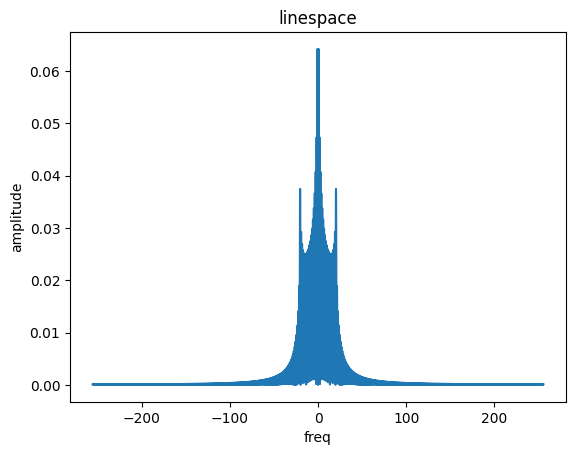

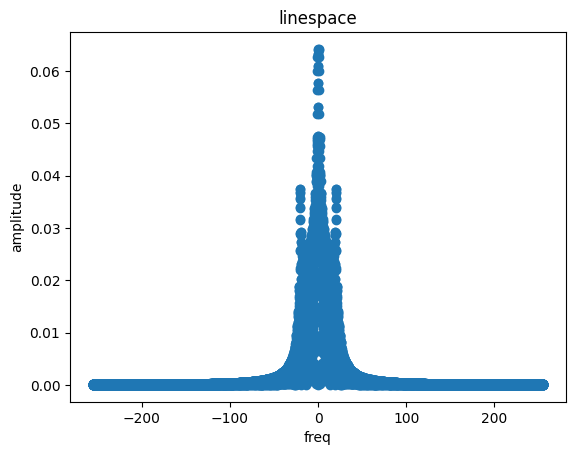

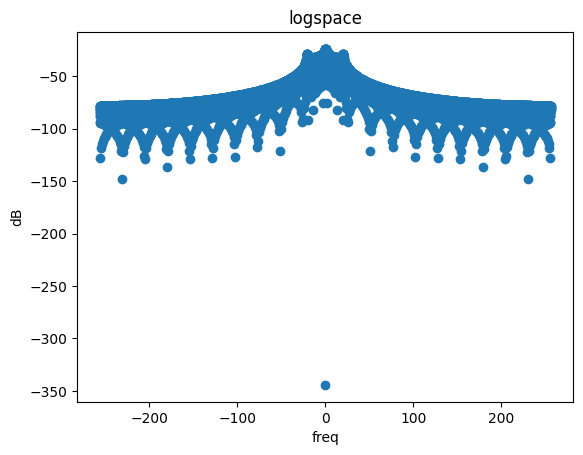

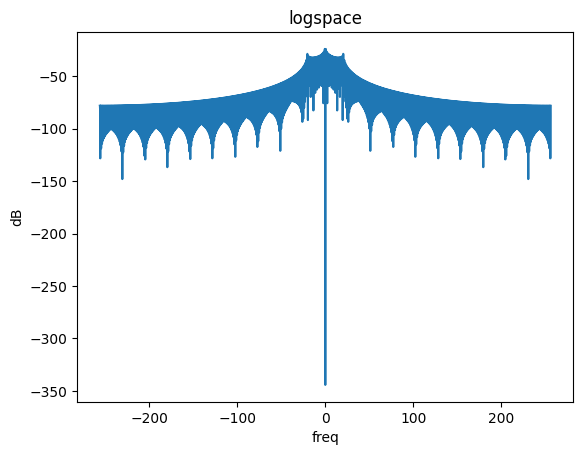

In [55]:
PlotAFR(fft,freq)

In [26]:
sferq=512
power=sum(filed_signal**2)/sferq
power

5.19593271009794